In [22]:
from bda.utils import plot_beta_binomial, summarize_beta_binomial, quantiles_beta, proba_beta, odds
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

# MoMA (Museum of Modern Art) Beispiel

Folgendes Modell wird verwendet:

$$
\begin{array}{rl}
Y \mid \pi &\sim \mathrm{Binomial}(100, \pi), \\[6pt]
\pi &\sim \mathrm{Beta}(4, 6), \\[6pt]
\Rightarrow &\pi \mid (Y = 14) \sim \mathrm{Beta}(18, 92).
\end{array}
$$


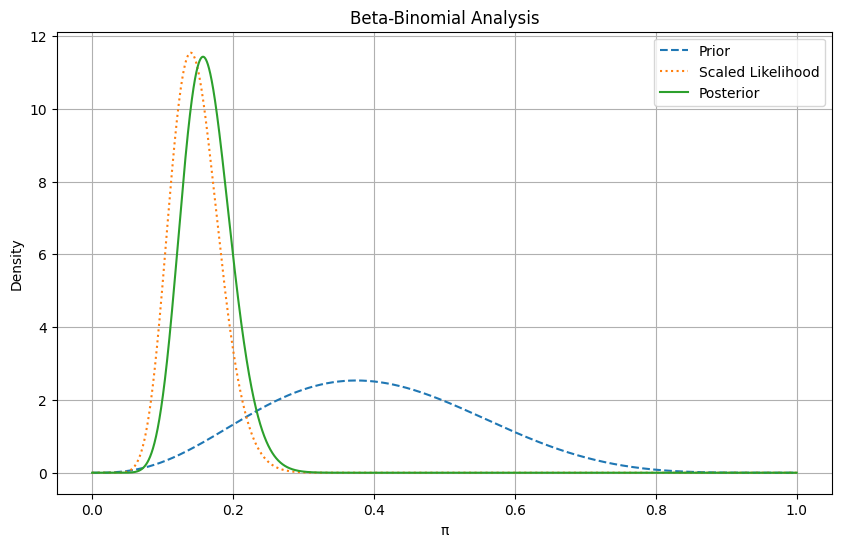

,alpha,beta,mean,mode,var,sd
model,,,,,,
prior,4,6,0.400000,0.375000,0.021818,0.147710
posterior,18,92,0.163636,0.157407,0.001233,0.035114


In [2]:
plot_beta_binomial(4, 6, 100, 14)
summarize_beta_binomial(4, 6, 100, 14)

## 8.1 Posterior estimation

95% Credible Intervall:

In [3]:
quantiles_beta(18, 92, [0.025, 0.975])

array([0.10090844, 0.23792856])

50% Credible Intervall:

In [4]:
quantiles_beta(18, 92, [0.25, 0.75])

array([0.1388414 , 0.18621971])

## 8.2 Posterior hypothesis testing

### 8.2.1 One-sided tests

$$
P(\pi < 0.2 \mid Y = 14) = \int_0^{0.2} f(\pi \mid Y = 14) \, d\pi.
$$


In [5]:
proba_beta(18, 92, pi_l_than=0.2)

(np.float64(0.848985555953253), None, None)

Und nun im Hypothesis-Testing Framework:

$$
\begin{aligned}
H_0 &: \pi \geq 0.2, \\
H_a &: \pi < 0.2.
\end{aligned}
$$

In [6]:
proba_beta(18, 92, pi_l_than=0.2, pi_h_than=0.2)

(np.float64(0.848985555953253), None, np.float64(0.15101444404674702))

Aus dem ganzen können nun die odds berechnet werden:

In [7]:
odds(proba_beta(18, 92, pi_l_than=0.2)[0])

np.float64(5.621883133844116)

Es ist somit also 5.6 mal wahrscheinlicher, dass die wahrscheinlichkeit < 0.2 ist.

### 8.2.2 Two-sided tests

Nun möchten wir testen, ob $\pi$ genau 0.3 ist:

$$
\begin{aligned}
H_0 &: \pi = 0.3, \\
H_a &: \pi \neq 0.3.
\end{aligned}
$$

So lässt sich das ganze allerdings nicht rechnen, da Beta kontinuierlich ist.

Deshalb muss von einem Intervall ausgegangen werden:

$$
\begin{aligned}
H_0 &: \pi \in (0.25, 0.35), \\
H_a &: \pi \notin (0.25, 0.35).
\end{aligned}
$$

In [9]:
proba_beta(18, 92, pi_between=[0.25, 0.35])

(None, np.float64(0.012500770337944167), None)

## 8.3 Posterior prediction

Nun möchten wir vorhersagen, wieviele hits wir bekommen, wenn wir 20 neue samples sammeln würden.  

Leider ist es nun nicht so einfach, dass wir den wert mit der grössten plausibilität nehmen würden:

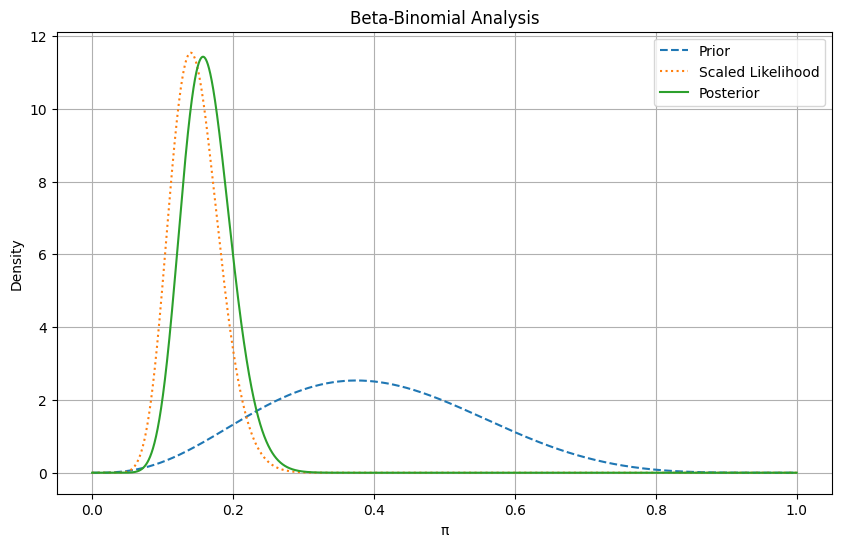

,alpha,beta,mean,mode,var,sd
model,,,,,,
prior,4,6,0.400000,0.375000,0.021818,0.147710
posterior,18,92,0.163636,0.157407,0.001233,0.035114


In [10]:
plot_beta_binomial(4, 6, 100, 14)
summarize_beta_binomial(4, 6, 100, 14)

Denn dann könnte man meinen, dass ca 20*0.157407 ~ 3 hits auf 20 Samples passieren würde. Aber wir vergessen, dass es einmal noch Variabilität in den Daten gibt und auch, dass $\pi$ selbst variiert.

Dies lässt sich in folgendes aufteilen:
- Sampling variability
- Posterior variabilitys

Die *Sampling variability* lässt sich mittels Binomialverteilung darstellen. Für $\pi = 0.1$ ist das folgendes:

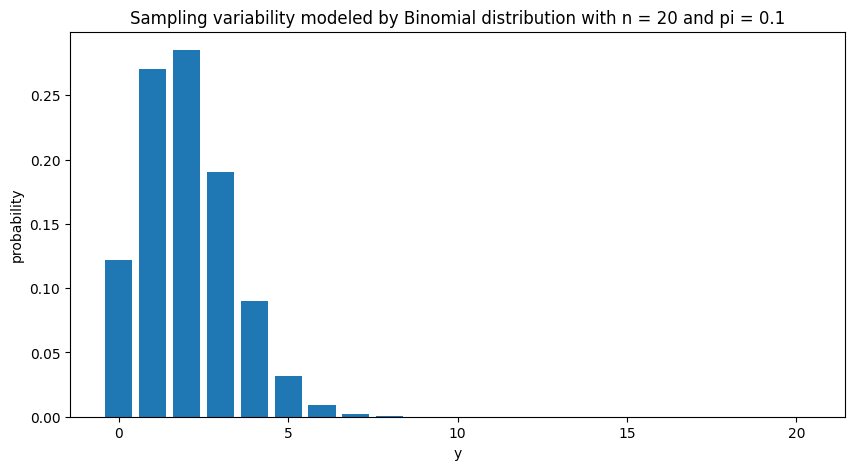

In [34]:
y = np.arange(0, 21)
proba = stats.binom(n=20, p=0.1).pmf(y)

plt.figure(figsize=(10, 5))
plt.bar(y, proba)
plt.title("Sampling variability modeled by Binomial distribution with n = 20 and pi = 0.1")
plt.xlabel("y")
plt.ylabel("probability")
plt.show()

Dies modeliert die Variabilität der Anzahl hits bei n=20 und pi von 0.1.  
Die Posterior variability wird gerade von der Posterior distribution modeliert. Somit müssen diese beiden nur noch verheiratet werden:

$$f(y^{'}|\pi)*f(\pi|y=14)$$

wobei $f(\pi|y=14)$ das Posterior Modell ist und $y^{'}$ die zu vorhersagende Variabel.


Nun muss das ganze noch marginalisiert werden, bzw $y^{'}$ über alle $\pi$'s betrachtet werden:

$$
f(y' \mid y) = \int f(y' \mid \pi) f(\pi \mid y) \, d\pi.
$$

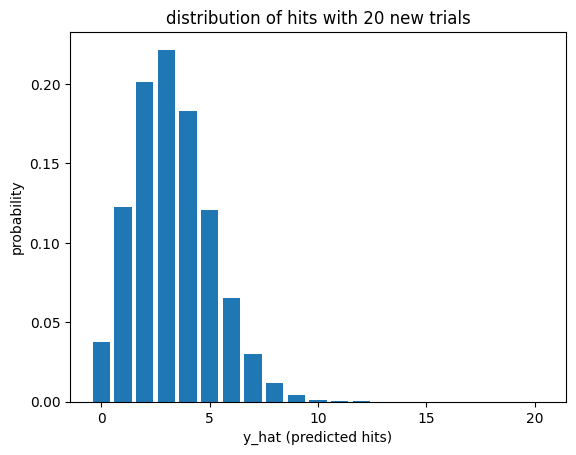

In [54]:
y = np.arange(0, 21)
pi = np.linspace(0, 1, 1000)

posterior_proba = stats.beta(18, 92).pdf(pi)

posterior_predictive_proba = []
for y_ in y:
    likelihood = stats.binom.pmf(n=20, k=y_, p=pi)

    marginalized = np.trapezoid(likelihood * posterior_proba, pi)

    posterior_predictive_proba.append(marginalized)

posterior_predictive_proba = np.array(posterior_predictive_proba)

plt.bar(y, posterior_predictive_proba)
plt.title("distribution of hits with 20 new trials")
plt.xlabel("y_hat (predicted hits)")
plt.ylabel("probability")
plt.show()

Nun ist die Wahrscheinlichkeit unter den 20 neuen datenpunkten k hits zu erzielen als wahrscheinlichkeit dargestellt. Nun kann damit weitergerechnet werden. Wie z.B:

- Was ist die Wahrscheinlichkeit, dass mindestens 5 hits erzielt werden?

In [55]:
posterior_predictive_proba[5:].sum()

np.float64(0.23298739435887847)

Somit ist die Wahrscheinlichkeit ca 23.3%, dass mindestens 5 hits erzielt werden.

Nun kann man noch den Erwartungswert berechnen:

In [56]:
np.sum(posterior_predictive_proba*np.arange(0, 21))

np.float64(3.2727272727272743)

# 8.4 Posterior analysis with MCMC